# Synthetic time series example

This notebook demonstrates the synthetic time series query feature on open industrial data

In [1]:
from matplotlib import pyplot as plt
import os
from datetime import datetime
from getpass import getpass
from cognite.client import CogniteClient

project = 'publicdata'
api_key = os.environ.get('PUBLICDATA_API_KEY') or getpass("Open Industrial Data API-KEY: ")
client = CogniteClient(project=project,api_key=api_key,client_name="STS demo")

Open Industrial Data API-KEY: ········


/Users/omarakabbal/opt/anaconda3/lib/python3.8/site-packages/cognite/client/_cognite_client.py:57: UserWarning: You are using version 2.2.1 of the SDK, however version 2.4.3 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  self._config = ClientConfig(


## In this tutorial, we will develop a simple synthetic time series for anomaly detection.

In [2]:
ts = client.time_series.retrieve_multiple(external_ids=['pi:160267','pi:160887'])
ts

,id,external_id,name,is_string,metadata,unit,asset_id,is_step,description,created_time,last_updated_time
0,7746696627668690,pi:160267,VAL_23-KA-9101-M01-62B:X.Value,False,"{'tag': 'VAL_23-KA-9101-M01-62B:X.Value', 'sca...",MW,5016064132476742,False,PH HV SWGR 1stStg Comp Mtr,1593024714298,1593512799826
1,5793880463497190,pi:160887,VAL_23-TT-92602:X.Value,False,"{'tag': 'VAL_23-TT-92602:X.Value', 'scan': '1'...",NaN,4893464693639605,False,PH 1stStgDiscCool Gas In,1593024714298,1593512884811


## We start with a simple linear regression model

In [3]:
df = client.datapoints.retrieve_dataframe(external_id=['pi:160267','pi:160887'],
                                  start=datetime(2019,10,1),end=datetime(2020,2,1),
                                  aggregates=['interpolation'],granularity='10s',complete='fill,dropna')

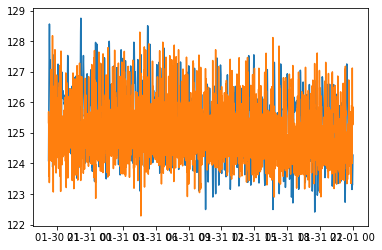

In [4]:
from scipy import stats
r = stats.linregress(df)
plt.plot(df.iloc[-10000:,1])
plt.plot(df.iloc[-10000:,0] * r.slope + r.intercept)

## We define the formula via sympy for convenience, avoiding the API syntax

In [5]:
from sympy import symbols
x,y = symbols(['x','y'])
y_pred = x * r.slope + r.intercept

In [6]:
error = 100 * abs(y - y_pred) / (abs(y) + 1e-6) # relative error in %

## let's test our query!

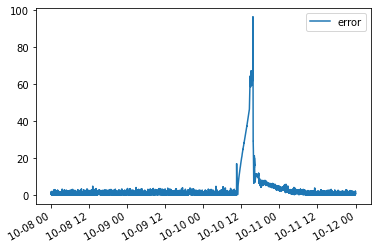

In [7]:
f = "TS{externalId:'sine'} + TS{externalId:'line'}"
dpt = client.datapoints.synthetic.query(expressions=error,
                                           variables={'x':ts[0],'y':ts[1]},
                                           start=datetime(2019,10,8),end=datetime(2019,10,12))
df = dpt.to_pandas()
df.columns = ['error']
df.plot()

In [8]:
## Curiously we have found a period with high error in our model on the first try!